# EfficientNetB0 Fine-Tuning
This notebook fine-tunes the `EfficientNetB0` model using hyperparameters obtained from Bayesian optimization.  
 
It includes:
- Loading the best-tuned hyperparameters  
- Progressive unfreezing of MBConv blocks  
- Fine-tuning with early stopping and learning rate scheduling  
- Evaluation on validation and test sets (accuracy, F1, precision, recall, confusion matrix)

In [1]:
import sys, os
import copy
import json
sys.path.append(os.path.abspath(".."))

import torch
import torch.nn as nn
from torchvision import models
import numpy as np
from tqdm.notebook import tqdm
from sklearn.metrics import f1_score, accuracy_score, classification_report

from src.data import get_datasets
from src.utils import set_device, EarlyStopper, is_mbconv, get_predictions
from src.train import train_step, val_step
from src.visualization import plot_curves, plot_confusion_matrix

## 1. Hyperparameter Setup and General Config

In [ ]:
# Define the path to saved optimal hyperparameters
file_path = '../outputs/param-optim/best_hyperparameters.json'

# Open and load the file into a dictionary
with open(file_path, 'r') as f:
    best_params = json.load(f)

print("Loaded Hyperparameters:")
print(best_params)

Loaded Hyperparameters:
{'LR': 0.0006358417306510211, 'BATCH_SIZE': 64, 'WEIGHT_DECAY': 0.0053798915552686665, 'UNFREEZE_K': 6}


In [3]:
# -- Settings --
EPOCHS = 5 # setting small number cause the model converges very quickly
DEVICE = set_device()
MODEL_SAVE_PATH = os.path.join("../outputs/models", "best_model.pth")
os.makedirs("../outputs", exist_ok=True)

# -- Load Datasets --
datasets = get_datasets(root="../data/augmented_images")
train_ds, val_ds, test_ds = datasets["train"], datasets["val"], datasets["test"]
class_names = train_ds.classes

print(f"Training samples: {len(train_ds)}")
print(f"Validation samples: {len(val_ds)}")
print(f"Test samples: {len(test_ds)}")
print(f"Number of classes: {len(class_names)}")

Device: mps
Training samples: 2246
Validation samples: 214
Test samples: 214
Number of classes: 8


In [4]:
# --- DataLoaders ---
pin_memory = torch.cuda.is_available()
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=best_params['BATCH_SIZE'], shuffle=True, pin_memory=pin_memory)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size=best_params['BATCH_SIZE'], pin_memory=pin_memory)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=best_params['BATCH_SIZE'], pin_memory=pin_memory)

In [5]:
# --- Model Setup ---
weights = models.EfficientNet_B0_Weights.IMAGENET1K_V1
model = models.efficientnet_b0(weights=weights)
in_features = model.classifier[-1].in_features
model.classifier = nn.Linear(in_features, len(class_names))
model.to(DEVICE)

# --- Progressive Unfreezing Logic ---
print(f"Unfreezing the last {best_params['UNFREEZE_K']} MBConv blocks...")
for p in model.features.parameters():
    p.requires_grad = False

mbconv_blocks = [m for m in model.features.modules() if is_mbconv(m)]
K = min(best_params['UNFREEZE_K'], len(mbconv_blocks))

for m in mbconv_blocks[-K:]:
    for p in m.parameters():
        p.requires_grad = True

# Always unfreeze the final conv block and the classifier
for p in model.features[-1].parameters():
    p.requires_grad = True
for p in model.classifier.parameters():
    p.requires_grad = True


Unfreezing the last 6 MBConv blocks...


In [6]:
# --- Optimizer, Scheduler, and Loss ---
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=best_params['LR'], weight_decay=best_params['WEIGHT_DECAY'])
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

# --- Initialization ---
history = {
    'train_loss': [], 'val_loss': [],
    'train_acc': [], 'val_acc': [],
    'train_f1': [], 'val_f1': []
}
best_model_state = None

# --- Early Stopper ---
EARLY_STOP_MONITOR = "f1_macro"
early_stopper = EarlyStopper(mode="max", patience=5, max_overfit_gap=0.10)

## 2. Fine-Tuning
Early stopping monitors the loss gap (val_loss−train_loss) and stops training if it exceeds 0.10. When this happens, the best weights so far (from the epoch before the trigger) are kept.

The triggering epoch is not recorded in the training history. This keeps overfitting in check while preserving the strongest validating model.

In [7]:
pbar = tqdm(range(1, EPOCHS + 1), desc="Epochs")

# --- Training Loop ---
for epoch in pbar:
    # --- Training & Validation Steps ---
    train_metrics = train_step(model, train_loader, criterion, optimizer, DEVICE, scheduler=scheduler)
    val_metrics = val_step(model, val_loader, criterion, DEVICE)

    # --- Update Progress Bar ---
    pbar.set_postfix(
        train_loss=f"{train_metrics['loss']:.3f}",
        val_loss=f"{val_metrics['loss']:.3f}",
        val_f1=f"{val_metrics['f1_macro']:.3f}"
    )

    # --- Early Stopping Check ---
    val_patience_metric = val_metrics[EARLY_STOP_MONITOR]

    improved, should_stop, reason = early_stopper.step(
        val_patience_metric=val_patience_metric,
        train_loss=train_metrics['loss'],
        val_loss=val_metrics['loss']
    )

    if improved and not should_stop:
        print(f"\nValidation F1 improved to {val_patience_metric:.4f}. Saving model state.")
        best_model_state = copy.deepcopy(model.state_dict())
        torch.save(best_model_state, MODEL_SAVE_PATH)

    if should_stop:
        print(f"\nEarly stopping triggered after epoch {epoch} because {reason}. Restoring best model.")
        break

    # --- Store Metrics ---
    history['train_loss'].append(train_metrics['loss'])
    history['val_loss'].append(val_metrics['loss'])
    history['train_acc'].append(train_metrics['accuracy'])
    history['val_acc'].append(val_metrics['accuracy'])
    history['train_f1'].append(train_metrics['f1_macro'])
    history['val_f1'].append(val_metrics['f1_macro'])

# --- Post-Training ---
# Load the best performing model state for evaluation
if best_model_state:
    model.load_state_dict(best_model_state)
else:
    print("Warning: Training finished without a best model state being saved.")

Epochs:   0%|          | 0/5 [00:00<?, ?it/s]


Validation F1 improved to 0.6909. Saving model state.



Validation F1 improved to 0.7585. Saving model state.



Early stopping triggered after epoch 3 because overfitting gap of 0.3237 exceeded the max of 0.1. Restoring best model.


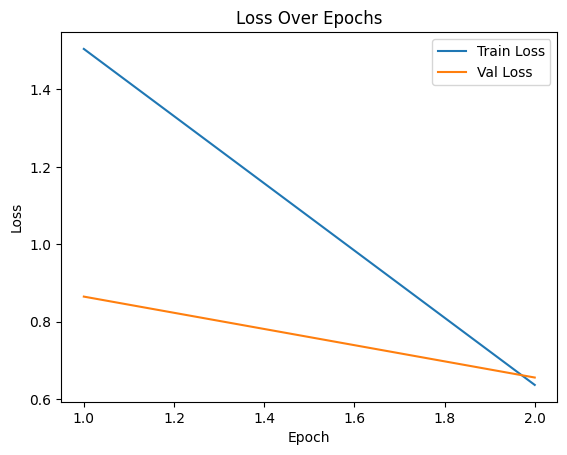

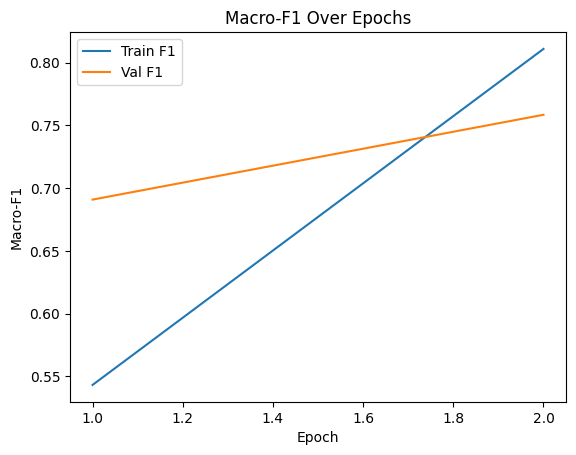

In [8]:
# Plot Loss and Macro-F1 Curves
plot_curves(history)

Training converged early, by epoch 2. Loss drops for both train and validation. Macro-F1 changes sharply at the start: the train set begins around 0.55, and by the first epoch the validation score is ~0.7—about 0.15 higher than the F1 at the start of epoch 1. After the second epoch, validation F1 barely changes while the train metrics keep improving, which is a sign of overfitting beginning.

By epoch 3 the train–val loss gap is ~0.3, a strong overfitting signal, so training was stopped at epoch 2.

## 3. Evaluation on Test Set

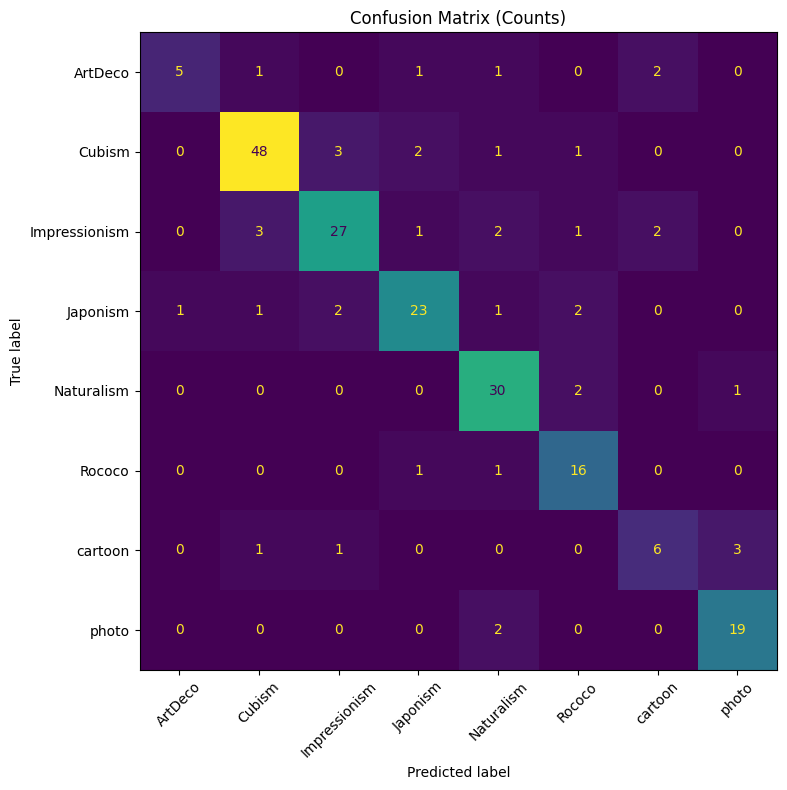

In [9]:
# --- Generate and Plot Confusion Matrix ---
y_true_cm, y_pred_cm = get_predictions(model, test_loader, DEVICE)

plot_confusion_matrix(y_true_cm, y_pred_cm, class_names)

In [ ]:
# --- Get Detailed Statistics ---
report = classification_report(
    y_true_cm, 
    y_pred_cm, 
    target_names=class_names, 
    zero_division=0
)
print(report)

               precision    recall  f1-score   support

      ArtDeco       0.83      0.50      0.62        10
       Cubism       0.89      0.87      0.88        55
Impressionism       0.82      0.75      0.78        36
     Japonism       0.82      0.77      0.79        30
   Naturalism       0.79      0.91      0.85        33
       Rococo       0.73      0.89      0.80        18
      cartoon       0.60      0.55      0.57        11
        photo       0.83      0.90      0.86        21

     accuracy                           0.81       214
    macro avg       0.79      0.77      0.77       214
 weighted avg       0.82      0.81      0.81       214



Model accuracy is 0.81 and macro-F1 score is 0.77 on the test set.

Strong classes: Cubism, Naturalism, Photo (precision/recall mostly 0.8–0.9). 

Mid-tier: Impressionism, Japonism, Rococo (F1 ≈ 0.79–0.80).

Weak classes: ArtDeco (recall 0.50) and cartoon (F1 0.57). These are also the smallest classes initially; most of the training samples are augmented rather than original images.

Macro avg 0.77 vs weighted avg 0.81 shows better performance on larger classes. 

It seems that the major issue is relying on augumented versions of images on underrepresented classes which possibly could result in the to synthetic artifacts rather than true class cues.